In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import class_weight
from tensorflow.keras import optimizers, regularizers

from prosenet import ProSeNet, datasets

In [2]:
# Set any non-default args
new_rnn_args = {
    'layers' : [32, 32, 32],
    'layer_args' : {
        'dropout' : 0.1,
        'activity_regularizer' : regularizers.l2(0.5)
    }
}

new_proto_args = {
    'dmin' : 2.0,
    'Ld' : 1.0, #0.1,
    'Lc' : 0.01,
    'Le' : 0.1 #1.0
}

pnet = ProSeNet(input_shape=(187, 1), 
                nclasses=5, 
                k=30, 
                rnn_args=new_rnn_args,
                prototypes_args=new_proto_args,
                L1=0.0)

pnet.build( (None, 187, 1) )

pnet.summary()

Model: "pro_se_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64)                58368     
_________________________________________________________________
prototypes (Prototypes)      multiple                  1920      
_________________________________________________________________
classifier (Dense)           multiple                  150       
Total params: 60,438
Trainable params: 60,438
Non-trainable params: 0
_________________________________________________________________


In [3]:
data = datasets.ArrhythmiaDataset('../data/')
print(data)

MIT-BIH Arrhythmia Dataset
Num classes: 5
Input shape: (187, 1)



In [4]:
train_gen = datasets.DataGenerator(data.X_train, data.y_train, batch_size=128)

test_gen = datasets.DataGenerator(data.X_test, data.y_test, batch_size=128)

class_weights = 1 - (np.bincount(np.argmax(data.y_train, 1)) / data.y_train.shape[0])

# Setting class 0 to 0.001, need to just get it to stop overfitting that class
class_weights[0] = 0.0

In [5]:
sgd = optimizers.SGD(learning_rate=0.1, clipnorm=5.0)

pnet.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

pnet.fit_generator(train_gen, 
                   validation_data=test_gen, 
                   epochs=2,
                   class_weight=class_weights,
                   shuffle=False)

Epoch 1/2
685/685 [==============================] - 75s 109ms/step - loss: 2793.1198 - accuracy: 0.7854 - val_loss: 934.9437 - val_accuracy: 0.8276
Epoch 2/2
685/685 [==============================] - 72s 105ms/step - loss: 2805.7520 - accuracy: 0.8276 - val_loss: 934.7495 - val_accuracy: 0.8276


In [6]:
pnet.predict(data.X_train[:3,:], batch_size=1)

array([[0.8950023 , 0.01932888, 0.03908747, 0.00643993, 0.04014139],
       [0.8950024 , 0.01932886, 0.03908744, 0.00643992, 0.04014134],
       [0.8950024 , 0.01932886, 0.03908744, 0.00643992, 0.04014134]],
      dtype=float32)

In [7]:
data.y_train[:3]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [8]:
pnet.predict(data.X_test[-3:,:], batch_size=1)

array([[0.8950024 , 0.01932887, 0.03908744, 0.00643992, 0.04014136],
       [0.8950024 , 0.01932886, 0.03908744, 0.00643992, 0.04014134],
       [0.89500207, 0.01932891, 0.03908754, 0.00643994, 0.04014145]],
      dtype=float32)

In [9]:
data.y_test[-3:]

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

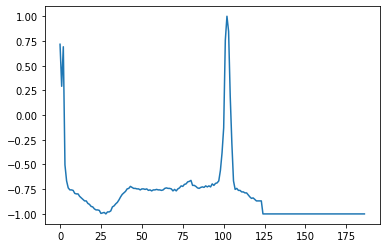

In [10]:
plt.plot(np.arange(187), data.X_train[-2])

In [11]:
class_weights

array([0.        , 0.97460995, 0.93389223, 0.9926788 , 0.92654819])

In [12]:
pnet.classifier.weights

[<tf.Variable 'classifier/kernel:0' shape=(30, 5) dtype=float32, numpy=
 array([[0.09048506, 0.12542507, 0.03628762, 0.01283509, 0.01660775],
        [0.09540263, 0.20285931, 0.03628762, 0.01283509, 0.07082349],
        [0.11084569, 0.37440315, 0.03628762, 0.22352357, 0.15897498],
        [0.08792616, 0.01488494, 0.08395585, 0.01283509, 0.1752603 ],
        [0.13170233, 0.22020781, 0.03628762, 0.01283509, 0.01660775],
        [0.08792616, 0.01488494, 0.03628762, 0.12802368, 0.15182118],
        [0.2629886 , 0.01488494, 0.21035533, 0.16559017, 0.01660775],
        [0.30563417, 0.01488494, 0.03628762, 0.26486003, 0.01660775],
        [0.31449872, 0.01488494, 0.13142163, 0.11563697, 0.01660775],
        [0.10164528, 0.32245687, 0.03628762, 0.3206175 , 0.01660775],
        [0.46750432, 0.01488494, 0.3241684 , 0.01283509, 0.01660775],
        [0.09014615, 0.01488494, 0.22886066, 0.01283509, 0.01660775],
        [0.0951149 , 0.01567347, 0.2350141 , 0.11809453, 0.01660775],
        [0.4000755

In [13]:
protos = np.squeeze(pnet.prototypes_layer.weights[0].numpy())
protos.min()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

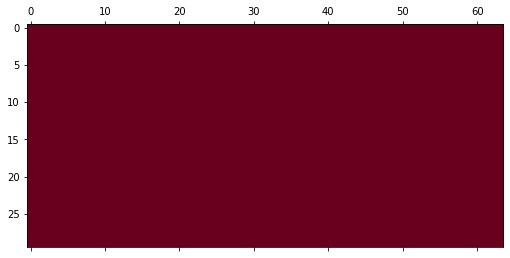

In [14]:
plt.matshow(protos, cmap=plt.cm.RdBu)

In [15]:
pnet.encoder.predict(data.X_train[-2:,:])

array([[0.9996506 , 0.99965   , 0.99965024, 0.9996502 , 0.99965   ,
        0.9996501 , 0.99965006, 0.99964994, 0.9996499 , 0.9996501 ,
        0.9996502 , 0.99965006, 0.9996497 , 0.9996501 , 0.99964994,
        0.9996502 , 0.9996499 , 0.99965036, 0.99965   , 0.99965   ,
        0.99965006, 0.9996502 , 0.9996503 , 0.9996502 , 0.9996503 ,
        0.9996499 , 0.99965   , 0.9996504 , 0.9996499 , 0.9996497 ,
        0.99965024, 0.9996499 , 0.99965   , 0.9996502 , 0.99965036,
        0.99964976, 0.99965036, 0.99964964, 0.99965066, 0.99965036,
        0.9996501 , 0.99965006, 0.9996503 , 0.9996501 , 0.99964976,
        0.9996502 , 0.99965006, 0.99965036, 0.99965024, 0.99965024,
        0.99965   , 0.9996503 , 0.99965024, 0.9996503 , 0.9996503 ,
        0.99965006, 0.99964994, 0.99965066, 0.99965   , 0.9996501 ,
        0.99965   , 0.9996506 , 0.99965024, 0.9996503 ],
       [0.9996506 , 0.99965   , 0.99965024, 0.9996502 , 0.99965   ,
        0.9996501 , 0.99965006, 0.99964994, 0.9996499 , 0.9

In [16]:
pnet.encoder.predict(data.X_train[:2,:])

array([[0.9996506 , 0.99965   , 0.99965024, 0.9996502 , 0.99965   ,
        0.9996501 , 0.99965006, 0.99964994, 0.9996499 , 0.9996501 ,
        0.9996502 , 0.99965006, 0.9996497 , 0.9996501 , 0.99964994,
        0.9996502 , 0.9996499 , 0.99965036, 0.99965   , 0.99965   ,
        0.99965006, 0.9996502 , 0.9996503 , 0.9996502 , 0.9996503 ,
        0.9996499 , 0.99965   , 0.9996504 , 0.9996499 , 0.9996497 ,
        0.99965024, 0.9996499 , 0.99965024, 0.9996502 , 0.99965024,
        0.99964976, 0.9996501 , 0.99964976, 0.99965054, 0.99965036,
        0.9996501 , 0.9996502 , 0.9996502 , 0.99965   , 0.9996499 ,
        0.99965006, 0.9996502 , 0.99965024, 0.9996501 , 0.9996501 ,
        0.9996501 , 0.99964994, 0.9996502 , 0.9996502 , 0.99965024,
        0.99965006, 0.9996502 , 0.9996503 , 0.99965024, 0.9996502 ,
        0.9996501 , 0.99965036, 0.9996499 , 0.99965054],
       [0.9996506 , 0.99965   , 0.99965024, 0.9996502 , 0.99965   ,
        0.9996501 , 0.99965006, 0.99964994, 0.9996499 , 0.9

In [17]:
pnet.prototypes_layer._diversity_term()

<tf.Tensor: id=3100459, shape=(), dtype=float32, numpy=1800.0>

In [18]:
pnet.losses

[<tf.Tensor 'pro_se_net/sequential/bidirectional/forward_lstm0/ActivityRegularizer/truediv:0' shape=() dtype=float32>,
 <tf.Tensor 'pro_se_net/sequential/bidirectional/backward_lstm0/ActivityRegularizer/truediv:0' shape=() dtype=float32>,
 <tf.Tensor 'pro_se_net/sequential/bidirectional_1/forward_lstm1/ActivityRegularizer/truediv:0' shape=() dtype=float32>,
 <tf.Tensor 'pro_se_net/sequential/bidirectional_1/backward_lstm1/ActivityRegularizer/truediv:0' shape=() dtype=float32>,
 <tf.Tensor 'pro_se_net/sequential/bidirectional_2/forward_lstm2/ActivityRegularizer/truediv:0' shape=() dtype=float32>,
 <tf.Tensor 'pro_se_net/sequential/bidirectional_2/backward_lstm2/ActivityRegularizer/truediv:0' shape=() dtype=float32>,
 <tf.Tensor 'pro_se_net/prototypes/Const:0' shape=() dtype=float32>,
 <tf.Tensor 'pro_se_net/prototypes/Const_1:0' shape=() dtype=float32>,
 <tf.Tensor 'pro_se_net/prototypes/Const_2:0' shape=() dtype=float32>,
 <tf.Tensor: id=3100460, shape=(), dtype=float32, numpy=0.0>]

In [19]:
pnet.loss_weights